In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import train_test_split

import xgboost as xgb
import lightgbm as lgb
from xbart import XBART

import random
random.seed(6)
import sys
import time

from sklearn.base import BaseEstimator
from bayes_opt import BayesianOptimization

## Data preparation

In [71]:
data = pd.read_csv("CRIS_processed.csv")
data['DVMT'] = np.log(data['DVMT']+1)
# remove the outlier ojectID: 48553
data = data[data['count_nearest_ped']<100]
data.head()

,OBJECTID,LEN_SEC,NUM_LANES,MED_WID,shoulder_w,on_system,curve_ind,SUM_length,MAX_EST_CU,ADT_ADJ,...,pop_den,job_den,PrecipInch,HOS_DIST,transit_ind,Cnt_TARGET,transit_density,school_dist,count_nearest_ped,count_nearest_pedfatal
0,4917,0.030,2,0,0.0,1,1,25.187955,36.3,3423,...,40.312369,12.404877,31,3.658316e-06,0,0,0.0,5.727588,0,0
1,4563,0.075,2,0,10.0,1,1,5.529078,36.3,3423,...,40.312369,12.404877,31,3.662212e-06,0,0,0.0,5.751043,0,0
2,5772,0.265,2,0,6.0,1,1,190.520702,53.8,3423,...,40.312369,12.404877,31,3.682394e-06,0,0,0.0,5.820311,0,0
3,8139,0.067,2,0,0.0,1,1,56.198763,55.4,3423,...,40.312369,12.404877,31,3.771042e-06,0,0,0.0,5.882193,0,0
4,3822,0.225,2,0,4.0,1,1,46.583045,23.3,12998,...,3854.279022,200.470515,51,7.436792e-07,0,0,0.0,0.606257,0,0


In [72]:
# Check NA
np.sum(data.isna())

OBJECTID                  0
LEN_SEC                   0
NUM_LANES                 0
MED_WID                   0
shoulder_w                0
on_system                 0
curve_ind                 0
SUM_length                0
MAX_EST_CU                0
ADT_ADJ                   0
TRK_AADT_P                0
AADT2                     0
DVMT                      0
SPD_MAX                   0
RU_1                      0
RU_2                      0
RU_3                      0
RU_4                      0
pop_den                   0
job_den                   0
PrecipInch                0
HOS_DIST                  0
transit_ind               0
Cnt_TARGET                0
transit_density           0
school_dist               0
count_nearest_ped         0
count_nearest_pedfatal    0
dtype: int64

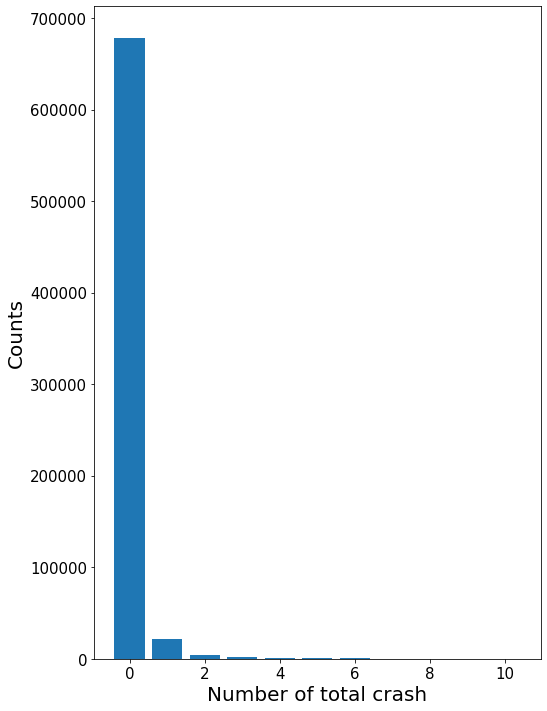

In [69]:
# quick view on the distribution of total crash
out = []
for i in range(11):
    out.append(data[data['count_nearest_ped']==i].shape[0])

fig, ax = plt.subplots(figsize=(8,12))
plt.bar(range(11),out)
plt.ylabel('Counts',fontsize=20)
plt.xlabel('Number of total crash',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.savefig('Total crash count distribution.jpg')

In [66]:
df_count = pd.DataFrame(index=range(11),columns=['Total number of crash perroad segment','Percentage'])
for i in range(11):
    df_count.iloc[i,:]=[int(i),100*data[data['count_nearest_ped']==i].shape[0]/data.shape[0]]

In [67]:
df_count

,Total number of crash perroad segment,Percentage
0,0,95.7558
1,1,2.97586
2,2,0.627877
3,3,0.23817
4,4,0.120637
5,5,0.0780261
6,6,0.0476905
7,7,0.0338631
8,8,0.0244096
9,9,0.0191891


In [78]:
# data_5 = data[data['count_nearest_ped']<=5]
# data_10 = data[data['count_nearest_ped']<=10]
# data_20 = data[data['count_nearest_ped']<=20]
# extract a small dataset
mask = np.random.rand(len(data)) < 0.01
data_small = data[mask]

In [79]:
features = ['DVMT','NUM_LANES','MED_WID','shoulder_w','on_system','curve_ind','MAX_EST_CU','SPD_MAX',\
 'AADT2', 'TRK_AADT_P','pop_den','job_den','RU_1','RU_2','RU_3','RU_4',\
 'PrecipInch','school_dist','HOS_DIST', 'transit_ind','Cnt_TARGET']

# shit to fatal count prediction by changing the target to 'count_nearest_pedfatal'
target = 'count_nearest_ped'
crashTarget = 'count_nearest_ped' if target=='count_nearest_ped' else 'count_nearest_pedfatal'

# categorical variables
cat_vars = ['on_system','curve_ind','RU_1','RU_2','RU_3','RU_4','transit_ind']

In [ ]:
#Variable description
#LEN_EC= segment length, NUM_LANES= number of lanes, MED_WID= Median width, shoulder_w = shoulder width
#on_system= on system roads =1, curve_ind= segment contains a curve =1, SUM_length = curve length
# MAX_EST_CU = curve angle, ADT_ADJ = AADT, TRK_AADT_P = % of truck AADT, AADT2 = historical AADT per lane
# DVMT = VMT, SPD_MAX= speed limit, RU_1= Rural (pop <5000), RU_2= Small urban (pop:5000-49999)
# RU_3= Urbanized (Pop:50000-199999),RU_4= Large urbanized (Pop: 200000+), 
# pop_den = population density (per sq mile),job_den = job density (per sq mile),
# PrecipInch = avg annual precipitation in inches, HOS_DIST = distance to nearest hospital (miles)
#transit_ind = transit stop within 100 meter buffer =1,Cnt_TARGET = Number of transit stops within 100 m buffer,
#transit_density= transit stops per mile, school_dist = distance to nearest school (miles), 
#count_nearest_ped = number of ped crashes, count_nearest_pedfatal = number of fatal ped crashes

## Models setting

### Negative Binomial 

In [80]:
formula_total ="count_nearest_ped ~ "+'+'.join(features)
formula_fatal = 'count_nearest_pedfatal ~ '+'+'.join(features)
formula = formula_total if target=='count_nearest_ped' else formula_fatal

In [89]:
# Negative Binomial for Bayesian Optimization 
# add get_params() and set_params() to XBART
import statsmodels.api as sm
from patsy import dmatrices
# modeify NB for parameter fine tuning
class NegativeBinomialExtend(BaseEstimator):
    def __init__(self,alpha=1.0):
        self.alpha = alpha
        #take the estimator
        self.clfs = {}
        
    def fit(self,X, y):
        df_train = pd.concat([y,X], axis=1)
        y_dmatrix, X_dmatrix = dmatrices(formula, df_train, return_type='dataframe')
        model = sm.GLM(y_dmatrix, X_dmatrix,family=sm.families.NegativeBinomial(alpha=self.alpha))
        model = model.fit()
        self.clfs['model'] = model
        return self
    # have trouble to implement Bayesian Optimization 
    def predict(self, X, y=y_test):
        df_test = pd.concat([y,X], axis=1)
        y_dmatrix, X_dmatrix = dmatrices(formula, df_test, return_type='dataframe')
        nb2_predictions = self.clfs['model'].get_prediction(X_dmatrix)
        predictions_summary_frame = nb2_predictions.summary_frame()
        predictions = predictions_summary_frame['mean']
        return predictions  
    
    
def NegativeBinomialBayesianOptimization(X_dtrain, y_dtrain, X_dtest, y_dtest):
    def function(alpha):
        return cross_val_score(NegativeBinomialExtend(alpha=alpha),  
               X=X_dtrain, 
               y=y_dtrain, 
               cv=4,
               scoring='neg_mean_squared_error').mean()

    parameters = {"alpha": (0.1,3)}
    #optimize with BayesianOptimization
    bayes = BayesianOptimization(function, parameters)
    bayes.maximize(init_points=3, n_iter=7)
    optimal_params = bayes.max['params']
    return optimal_params   

In [100]:
X_train, X_test, y_train, y_test = train_test_split(data_small[features],data_small[crashTarget],test_size=0.2)

In [95]:
yy,xx= dmatrices(formula, data_small, return_type='dataframe')

In [103]:
xx

,Intercept,DVMT,NUM_LANES,MED_WID,shoulder_w,on_system,curve_ind,MAX_EST_CU,SPD_MAX,AADT2,...,job_den,RU_1,RU_2,RU_3,RU_4,PrecipInch,school_dist,HOS_DIST,transit_ind,Cnt_TARGET
99,1.0,6.557429,4.0,0.0,0.0,1.0,1.0,13.7,40.0,2791.5,...,495.036368,0.0,1.0,0.0,0.0,11.0,0.849056,4.517874e-07,0.0,0.0
147,1.0,5.746663,2.0,0.0,10.0,1.0,0.0,0.0,70.0,2787.0,...,551.955677,1.0,0.0,0.0,0.0,11.0,9.390873,4.438984e-06,0.0,0.0
220,1.0,7.731527,4.0,0.0,10.0,1.0,0.0,0.0,45.0,3955.0,...,374.805021,0.0,0.0,1.0,0.0,13.0,0.564377,4.318257e-07,0.0,0.0
377,1.0,1.516445,2.0,0.0,2.0,1.0,1.0,18.3,55.0,127.0,...,10.275100,1.0,0.0,0.0,0.0,20.0,0.400738,3.231204e-06,0.0,0.0
513,1.0,5.264678,2.0,0.0,8.0,1.0,1.0,94.7,50.0,501.0,...,39.058278,0.0,0.0,1.0,0.0,25.0,3.746451,2.754064e-06,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708442,1.0,1.673914,2.0,0.0,0.0,1.0,0.0,0.0,55.0,2166.5,...,143.631642,1.0,0.0,0.0,0.0,24.0,0.921102,1.876111e-07,0.0,0.0
708501,1.0,7.798386,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1124.5,...,8.258110,1.0,0.0,0.0,0.0,34.0,6.085522,6.697016e-06,0.0,0.0
708659,1.0,3.152736,2.0,0.0,0.0,0.0,0.0,0.0,60.0,16.0,...,10.053611,1.0,0.0,0.0,0.0,37.0,4.205182,5.774820e-06,0.0,0.0
708669,1.0,0.124869,2.0,0.0,0.0,0.0,0.0,0.0,60.0,66.5,...,13.963525,1.0,0.0,0.0,0.0,37.0,0.326927,6.312900e-06,0.0,0.0


In [104]:
X_train

,DVMT,NUM_LANES,MED_WID,shoulder_w,on_system,curve_ind,MAX_EST_CU,SPD_MAX,AADT2,TRK_AADT_P,...,job_den,RU_1,RU_2,RU_3,RU_4,PrecipInch,school_dist,HOS_DIST,transit_ind,Cnt_TARGET
231687,5.141196,2,0,0.0,0,0,0.0,60,120.0,3.2,...,35.265735,0,1,0,0,36,2.905418,2.660955e-06,0,0
262889,4.157570,2,0,0.0,0,0,0.0,0,107.0,3.2,...,35.700751,0,0,0,1,52,1.220986,3.290180e-06,0,0
492752,3.386422,2,0,0.0,0,0,0.0,0,127.5,3.2,...,139.967153,0,0,0,1,40,1.011785,2.435010e-07,0,0
255346,5.461541,2,0,0.0,0,0,0.0,0,95.0,3.2,...,4.253800,1,0,0,0,39,1.943208,2.281309e-06,0,0
540009,1.951608,2,0,0.0,0,0,0.0,0,20.0,3.2,...,2.885498,1,0,0,0,43,0.150960,4.796142e-06,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125937,7.306217,2,0,9.0,1,1,31.8,65,1573.5,16.1,...,11.269536,1,0,0,0,28,3.035293,3.440933e-06,0,0
519820,4.497785,2,0,0.0,0,0,0.0,0,196.5,3.2,...,401.524096,0,1,0,0,56,1.448665,9.515822e-07,0,0
13645,4.402417,2,0,4.0,1,1,95.4,75,34.0,17.7,...,85.375909,1,0,0,0,18,5.424857,4.173417e-06,0,0
660652,5.358518,2,0,0.0,0,0,0.0,0,202.5,3.2,...,161.865876,0,0,0,1,34,0.062222,3.767502e-07,0,0


In [90]:
NegativeBinomialExtend().fit(X_train,y_train).predict(X_test)

140235    2.364975
342895    0.003495
267488    0.000520
487117    0.014682
514042    0.086727
            ...   
350825    0.023657
419378    0.030714
635768    0.004107
628112    0.074302
203875    0.000298
Name: mean, Length: 1404, dtype: float64

In [91]:
pp = NegativeBinomialBayesianOptimization(X_train, y_train, X_test, y_test)

|   iter    |  target   |   alpha   |
-------------------------------------


ValueError: Found input variables with inconsistent numbers of samples: [1404, 0]

### Randomforest

In [8]:
def RandomForestBayesianOptimization(X_dtrain, y_dtrain, X_dtest, y_dtest):
    def function(n_estimators, max_depth, min_samples_split, min_samples_leaf,max_features):
        return cross_val_score(
               RandomForestRegressor(
                   n_estimators=int(max(n_estimators,0)),                                                               
                   max_depth=int(max(max_depth,1)),
                   min_samples_split=int(max(min_samples_split,2)),
                   min_samples_leaf = int(max(min_samples_leaf,1)),
                   max_features = int(max(max_features,1)),
                   n_jobs=-1, 
                   random_state=42),  
               X=X_dtrain, 
               y=y_dtrain, 
               cv=4,
               scoring='neg_mean_squared_error').mean()

    parameters = {"n_estimators": (10, 150),
                  "max_depth": (10, 100),
                  "min_samples_split": (2,10),
                 'min_samples_leaf':(1,10),
                 'max_features':(1,10)}
    #optimize with BayesianOptimization
    bayes = BayesianOptimization(function, parameters)
    bayes.maximize(init_points=3, n_iter=7)
    optimal_params = bayes.max['params']
    return optimal_params   

### XGBoost


In [17]:
#xgboost installed from pip
# !pip install xgboost

In [18]:
def XGBoostBayesianOptimization(X_dtrain, y_dtrain, X_dtest, y_dtest):
    xgb_train = 
    xgb_test = 
    
    def function(max_depth, subsample,gamma, colsample_bytree, max_leaves,max_bin, min_child_weight,colsample_bylevel,
                reg_alpha,reg_lambda,eta):
        params = {'objective': 'reg:squarederror',
                  'booster':'gbtree',
                  'max_depth': int(round(max_depth)),
                  'subsample': max(min(subsample, 1), 0),
                  'eta': max(eta,0),
                  'gamma': max(gamma, 0),
                  'colsample_bytree': max(min(colsample_bytree, 1), 0),
                  'max_leaves': int(round(max_leaves)),
                  'max_bin':int(round(max_bin)),
                  'min_child_weight':min_child_weight,
                  'colsample_bylevel':colsample_bylevel,
                  'reg_alpha':max(reg_alpha, 0),
                  'reg_lambda':max(reg_lambda, 0),
                   'random_state':42}
        cv_result = xgb.cv(params, xgb_train, nfold=3,seed=6, stratified=False, 
                           metrics=['rmse'],verbose_eval=25,early_stopping_rounds=50)    
        # Bayesian optimization only knows how to maximize, not minimize, so return the negative RMSE
        return -1.0 * cv_result['test-rmse-mean'].iloc[-1]
    
    parameters = {'max_depth': (0, 12), 
                  'gamma': (0, 1),
                  'subsample': (0.1, 0.9),
                  'max_leaves': (1000, 2000),
                  'colsample_bytree': (0.1, 0.9),
                  'reg_lambda': (0.1, 2),
                  'reg_alpha': (0.1, 2),
                  'max_bin':(180,500),
                  'colsample_bylevel':(0.1,0.9),
                  'min_child_weight': (3, 20),
                  'eta':(0,0.5)}
    #optimize with BayesianOptimization
    bayes = BayesianOptimization(function, parameters)
    bayes.maximize(init_points=3, n_iter=7)
    optimal_params = bayes.max['params']
    return optimal_params

### lightGBM

In [13]:
# BayesianOptimization to fune tune parameters
def lightGBMBayesinaOptimization(X_dtrain, y_dtrain, X_dtest, y_dtest):
    lgb_train = 
    lgb_test = 
    def function(num_leaves, colsample_bytree, subsample, max_depth, reg_lambda, reg_alpha, min_split_gain, min_child_weight, 
                 max_bin, subsample_freq):
        #general parameters
        params = {'objective':'regression','boosting_type': 'gbdt','verbose': -1, 'random_state':42, 'learning_rate':0.02}
        #fine-tuned parameters
        params['num_leaves'] = int(round(num_leaves))
        params['colsample_bytree'] = max(min(colsample_bytree, 1), 0)
        params['subsample'] = max(min(subsample, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['reg_lambda'] = max(reg_lambda, 0)
        params['reg_alpha'] = max(reg_alpha, 0)
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        params['max_bin']=int(round(max_bin))
        params['subsample_freq']=int(round(subsample_freq))
        
        cv_result = lgb.cv(params, lgb_train, nfold=3, seed=6, stratified=False, 
                       verbose_eval=25, metrics=['rmse'],early_stopping_rounds=50)
        return -1.0 * np.min(cv_result['rmse-mean'])
    
    parameters = {'num_leaves': (1000, 3000),
                  'colsample_bytree': (0.1, 0.9),
                  'subsample': (0.1, 0.9),
                  'max_depth': (-1, 12),
                  'reg_lambda': (0.1, 3),
                  'reg_alpha': (0.1, 3),
                  'max_bin':(180,600),
                  'subsample_freq':(1,20),
                  'min_split_gain': (0.1, 0.9),
                  'min_child_weight': (3, 30)}
    
    #optimize with BayesianOptimization
    bayes = BayesianOptimization(function, parameters)
    bayes.maximize(init_points=2, n_iter=4)
    optimal_params = bayes.max['params']
    return optimal_params

### XBART

In [22]:
from xbartExtend import xbartExtendRegressor

In [ ]:
def XBARTBayesianOptimization(X_dtrain, y_dtrain, X_dtest, y_dtest):
    def function(num_trees, beta, num_cutpoints, n_min,max_depth_num):
        ## may need to rewrite cross validation
        val = cross_val_score(xbartExtendRegressor(
                                          num_trees=int(max(num_trees,10)),
                                          beta=max(beta,0),
                                          num_cutpoints=int(max(num_cutpoints,2)),
                                          n_min=max(n_min,0),
                                          max_depth_num=int(max(max_depth_num,5))),
                             X=X_dtrain, 
                             y=y_dtrain,
                             scoring='neg_mean_absolute_error',
                             cv=4).mean()
        return val
    
    parameters = {'num_trees': (10,200),
                  'beta': (0,5),
                  'num_cutpoints': (2,200),
                  'n_min': (0,100),
                  'max_depth_num':(5,200)}
    #optimize with BayesianOptimization
    bayes = BayesianOptimization(function, parameters)
    bayes.maximize(init_points=2, n_iter=3)
    optimal_params = bayes.max['params']
    return optimal_params

'''computer crashed in 9th iteration of Bayesian Optimization for total count , but obtained the best params:
target: -0.1071, beta:2.231,max_depth_num:102, n_min:69.96,num_cutpoints:128, num_trees:21.34
'''

## Model evaluation and sensitivity analysis

In [ ]:
from sklearn.metrics import r2_score,mean_squared_error
import copy

In [ ]:
nb_r2=[];rfr_r2=[];xgb_r2=[];lgb_r2=[];xbart_r2=[]
nb_rmse=[];rfr_rmse=[];xgb_rmse=[];lgb_rmse=[];xbart_rmse=[]
nb_time=[];rfr_time=[];xgb_time=[];lgb_time=[];xbart_time=[]
final_sens={}

In [ ]:
def main(ddata):
    for iteration in range(10):
        ###############################Split data for train and test##########################################################
        X_train, X_test, y_train, y_test = train_test_split(ddata[features],ddata[crashTarget],test_size=0.2)
        
        ########################################Parameters fine tuning########################################################
        nb_params = NegativeBinomialBayesianOptimization(X_train, y_train, X_test, y_test)
        rfr_params = RandomForestBayesianOptimization(X_train, y_train, X_test, y_test)
        # convert integer parameter to an integer
        for para in rfr_params.keys():
            rfr_params[para] = int(round(rfr_params[para]))
            
        xgb_params = XGBoostBayesianOptimization(X_train, y_train, X_test, y_test)
        for para in ['max_depth','max_leaves','max_bin',]:
            xgb_params[para] = int(round(xgb_params[para]))
        xgb_general_params = {'objective': 'reg:squarederror','booster':'gbtree','random_state':42}
        # combine two set of parameters
        xgb_params = {**xgb_params,**xgb_general_params}
        
        lgb_params = lightGBMBayesinaOptimization(X_train, y_train, X_test, y_test)
        for para in ['num_leaves','max_depth','max_bin','subsample_freq']:
            lgb_params[para] = int(round(lgb_params[para]))
        lgb_general_params = {'objective':'regression','boosting_type': 'gbdt','verbose': -1,'metric':'rmse','learning_rate':0.02,'random_state':42}
        lgb_params = {**lgb_params,**lgb_general_params}
        
        # parameters for total crash count
        xbart_params_total = {'beta':2.231,'max_depth_num':102, 'n_min':69.96,'num_cutpoints':128, 'num_trees':21.34}
        xbart_params_fatal = {'beta':2.231,'max_depth_num':102, 'n_min':69.96,'num_cutpoints':128, 'num_trees':21.34}
        xbart_params = xbart_params_total if target==target = 'count_nearest_ped' else xbart_params_fatal
        print('Finished parameters fine tuning!\n')
        
        ############################## Model fitting######################################################################
        # Negative binomial 
        time1 = time.process_time()
        nb_model = NegativeBinomialExtend(**nb_params).fit(X_train, y_train)
        nb_preds = nb_model.predict(X_test, y_test)
        time2 = time.process_time()
        nb_time.append(time2-time1)
        nb_r2.append(r2_score(y_test, nb_preds))
        nb_rmse.append(mean_squared_error(y_test,nb_preds))
            
        # RandomForest
        time1 = time.process_time()
        rfr_model = RandomForestRegressor(**rfr_params).fit(X_train, y_train)
        rfr_preds = rfr_model.predict(X_test, y_test)
        time2 = time.process_time()
        rfr_time.append(time2-time1)
        rfr_r2.append(r2_score(y_test, rfr_preds))
        rfr_rmse.append(mean_squared_error(y_test,rfr_preds))
        
        # XGBoost 
        time1 = time.process_time()
        def xgb_dmagtrix(x1,y1):
            return xgb.DMatrix(data=x1,label=y1)
        xgb_model = xgb.train(xgb_params,xgb_dmagtrix(X_train,y_train),num_boost_round=200,evals=[(xgb_dmagtrix(X_test,y_test),'rmse')],early_stopping_rounds=50)
        xgb_preds = xgb_model.predict(X_test)
        time2 = time.process_time()
        xgb_time.append(time2-time1)
        xgb_r2.append(r2_score(y_test, xgb_preds))
        xgb_rmse.append(mean_squared_error(y_test,xgb_preds))
        
        # lightGBM 
        time1 = time.process_time()
        def lgb_dataset(x2,y2):
            return lgb.Dataset(data=x2, label = y2,free_raw_data = False)
        lgb_model = lgb.train(lgb_params, lgb_dataset(X_train,y_train), num_boost_round=200, valid_sets= [lgb_dataset(X_test,y_test)], early_stopping_rounds=50)
        lgb_preds = lgb_model.predict(X_test)
        time2 = time.process_time()
        lgb_time.append(time2-time1)
        lgb_r2.append(r2_score(y_test, lgb_preds))
        lgb_rmse.append(mean_squared_error(y_test,lgb_preds))
        
        # XBART
        time1 = time.process_time()
        xbart_model = xbartExtendRegressor(**xbart_params).fit(X_train,y_train)
        xbart_preds = xbart_model.predict(X_test)
        time2 = time.process_time()
        xbart_time.append(time2-time1)
        xbart_r2.append(r2_score(y_test, xbart_preds))
        xbart_rmse.append(mean_squared_error(y_test,xbart_preds))
        
        print('Finished model fitting!')
        
        ##################################### Sensitivity analysis#################################################################
        def get_sensitivity(model_list):
            columns = X_test.columns
            regressors = ['Negative Binomial','RandomForeset','XGBoost','ligthGBM','XBART']
            df_sensitivity = pd.DataFrame(index=regressors,columns=columns)

            for i in range(len(regressors)):
                for k,col in enumerate(columns):
                    copy_X = copy.copy(X_test)
                    if col in cat_vars:
                        copy_X[col] = copy_X[col].map({0:1,1:0})
                        df_sensitivity.iloc[i,k] = (model_list[i].predict(copy_X).mean()-y_test.mean())/y_test.mean()
                    
                    # need to disscuss how to deal with DVMT
                    else: 
                        std = copy_X[col].std()
                        copy_X[col] = copy_X[col]+std
                        df_sensitivity.iloc[i,k] = (model_list[i].predict(copy_X).mean()-y_test.mean())/y_test.mean()
            return df_sensitivity
        models = [nb_model,rfr_model,xgb_model,lgb_model,xbart_model]
        final_sens[iteration] = get_sensitivity(models)     

In [ ]:
if __name__=='__main__':
    # use all data
    main(data)

## Sensitivity plot

In [ ]:
#parallel coordinates plot
from pandas.plotting import parallel_coordinates


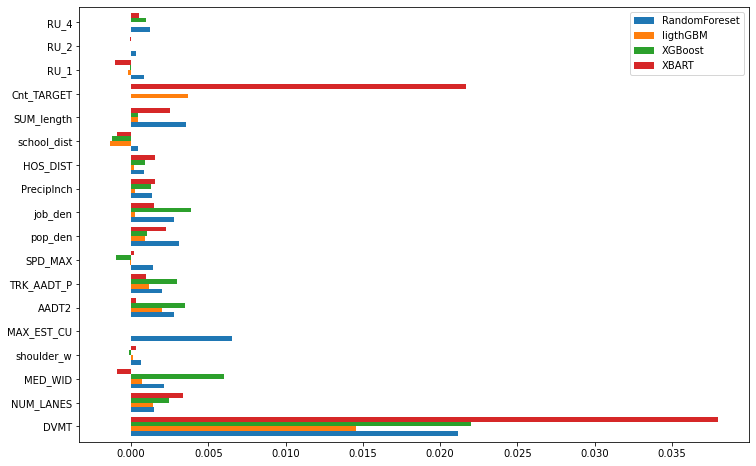

In [47]:
# bar graph
final_sens
sens_figure = df_sensivity.T.plot.barh(figsize=(12,8),width=0.8).get_figure()
sens_figure.savefig(title+'_sensitivity.pdf')